# David Kartchner
## Lab 10:  Style Transfer
## November 30, 2016

In [39]:
import numpy as np
import tensorflow as tf
import vgg16
from scipy.misc import imread, imresize, imsave
import matplotlib.pyplot as plt
from IPython.display import Image
%matplotlib inline
import matplotlib
matplotlib.rcParams['figure.figsize'] = (10, 10)

## Create Computation Graph and Read Images

In [40]:
tf.reset_default_graph()
sess = tf.Session()


opt_img = tf.Variable( tf.truncated_normal( [1,224,224,3],
                                        dtype=tf.float32,
                                        stddev=1e-1), name='opt_img' )

tmp_img = tf.clip_by_value( opt_img, 0.0, 255.0 )

vgg = vgg16.vgg16( tmp_img, 'vgg16_weights.npz', sess )

0 conv1_1_W (3, 3, 3, 64)
1 conv1_1_b (64,)
2 conv1_2_W (3, 3, 64, 64)
3 conv1_2_b (64,)
4 conv2_1_W (3, 3, 64, 128)
5 conv2_1_b (128,)
6 conv2_2_W (3, 3, 128, 128)
7 conv2_2_b (128,)
8 conv3_1_W (3, 3, 128, 256)
9 conv3_1_b (256,)
10 conv3_2_W (3, 3, 256, 256)
11 conv3_2_b (256,)
12 conv3_3_W (3, 3, 256, 256)
13 conv3_3_b (256,)
14 conv4_1_W (3, 3, 256, 512)
15 conv4_1_b (512,)
16 conv4_2_W (3, 3, 512, 512)
17 conv4_2_b (512,)
18 conv4_3_W (3, 3, 512, 512)
19 conv4_3_b (512,)
20 conv5_1_W (3, 3, 512, 512)
21 conv5_1_b (512,)
22 conv5_2_W (3, 3, 512, 512)
23 conv5_2_b (512,)
24 conv5_3_W (3, 3, 512, 512)
25 conv5_3_b (512,)


In [41]:
style_img = imread( 'content.png', mode='RGB' ).transpose((1,0,2))
print style_img.shape
style_img = imresize( style_img, (224, 224) )
style_img = np.reshape( style_img, [1,224,224,3] )

content_img = imread( 'jessica_wedding.jpg', mode='RGB' )
content_img = imresize( content_img, (224, 224) )
content_img = np.reshape( content_img, [1,224,224,3] )

layers = [ 'conv1_1', 'conv1_2',
           'conv2_1', 'conv2_2',
           'conv3_1', 'conv3_2', 'conv3_3',
           'conv4_1', 'conv4_2', 'conv4_3',
           'conv5_1', 'conv5_2', 'conv5_3' ]

ops = [ getattr( vgg, x ) for x in layers ]

content_acts = sess.run( ops, feed_dict={vgg.imgs: content_img } )
style_acts = sess.run( ops, feed_dict={vgg.imgs: style_img} )

style_indices = [0,2,4,7,10]
opt_vggs = [vgg.conv1_1, vgg.conv2_1, vgg.conv3_1, vgg.conv4_1, vgg.conv5_1]

(1600, 1200, 3)


## Create Appropriate Loss Function

In [42]:
content_loss = .5*tf.reduce_sum(tf.square(vgg.conv4_2-content_acts[8]))


Ns = [style_acts[i].shape[-1] for i in style_indices]
Ms = [np.prod(style_acts[i].shape[:-1]) for i in style_indices]
pre_gs = [tf.reshape(style_acts[i], [m,n]) for i, m, n in zip(style_indices,Ms, Ns)]
pre_as = [tf.reshape(layer, [m,n]) for layer, m, n in zip(opt_vggs, Ms, Ns)]

Gs = [tf.matmul(tf.transpose(g), g) for g in pre_gs]
As = [tf.matmul(tf.transpose(a), a) for a in pre_as]

Es = [(1./(4.*n**2*m**2))*tf.reduce_sum(tf.square(g-a)) for n, m, g, a in zip(Ns, Ms, Gs, As)]
style_loss = (1./len(Es))*tf.reduce_sum(Es)

alpha, beta = .001, 1
total_loss = alpha*content_loss + beta*style_loss



# Create Optimizer--Optimize only appropriate variable
optim = tf.train.AdamOptimizer(0.1, beta1=.5, epsilon=.1).minimize(total_loss, var_list = [opt_img])

# this clobbers all VGG variables, but we need it to initialize the
# adam stuff, so we reload all of the weights...
sess.run( tf.initialize_all_variables() )
vgg.load_weights( 'vgg16_weights.npz', sess )

# initialize with the content image
sess.run( opt_img.assign( content_img ))

0 conv1_1_W (3, 3, 3, 64)
1 conv1_1_b (64,)
2 conv1_2_W (3, 3, 64, 64)
3 conv1_2_b (64,)
4 conv2_1_W (3, 3, 64, 128)
5 conv2_1_b (128,)
6 conv2_2_W (3, 3, 128, 128)
7 conv2_2_b (128,)
8 conv3_1_W (3, 3, 128, 256)
9 conv3_1_b (256,)
10 conv3_2_W (3, 3, 256, 256)
11 conv3_2_b (256,)
12 conv3_3_W (3, 3, 256, 256)
13 conv3_3_b (256,)
14 conv4_1_W (3, 3, 256, 512)
15 conv4_1_b (512,)
16 conv4_2_W (3, 3, 512, 512)
17 conv4_2_b (512,)
18 conv4_3_W (3, 3, 512, 512)
19 conv4_3_b (512,)
20 conv5_1_W (3, 3, 512, 512)
21 conv5_1_b (512,)
22 conv5_2_W (3, 3, 512, 512)
23 conv5_2_b (512,)
24 conv5_3_W (3, 3, 512, 512)
25 conv5_3_b (512,)


array([[[[  30.,   52.,   42.],
         [  33.,   54.,   44.],
         [  33.,   54.,   42.],
         ..., 
         [ 237.,  235.,  238.],
         [ 237.,  235.,  238.],
         [ 236.,  234.,  237.]],

        [[  39.,   60.,   49.],
         [  41.,   61.,   50.],
         [  38.,   61.,   47.],
         ..., 
         [ 237.,  235.,  238.],
         [ 237.,  235.,  238.],
         [ 238.,  236.,  239.]],

        [[  43.,   61.,   48.],
         [  43.,   61.,   49.],
         [  45.,   66.,   50.],
         ..., 
         [ 237.,  235.,  238.],
         [ 237.,  235.,  238.],
         [ 237.,  235.,  238.]],

        ..., 
        [[   9.,   17.,   30.],
         [  11.,   16.,   30.],
         [   5.,   19.,   29.],
         ..., 
         [ 224.,  221.,  228.],
         [ 225.,  222.,  229.],
         [ 225.,  222.,  229.]],

        [[   8.,   17.,   25.],
         [   9.,   17.,   25.],
         [   7.,   17.,   25.],
         ..., 
         [ 225.,  222.,  229.],
       

## Run Optimizer

0 Loss: 989494208.0;  Content Loss: 0.0;  Style Loss: 989494208.0


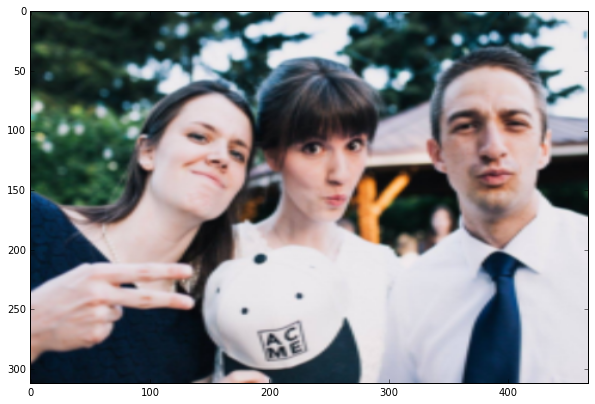

10 Loss: 825598080.0;  Content Loss: 356197056.0;  Style Loss: 825241856.0
20 Loss: 695061440.0;  Content Loss: 1000676224.0;  Style Loss: 694060736.0
30 Loss: 596719680.0;  Content Loss: 1614467328.0;  Style Loss: 595105216.0
40 Loss: 521505664.0;  Content Loss: 2175714304.0;  Style Loss: 519329952.0
50 Loss: 462408672.0;  Content Loss: 2683884800.0;  Style Loss: 459724800.0
60 Loss: 414884288.0;  Content Loss: 3128224512.0;  Style Loss: 411756064.0
70 Loss: 375782016.0;  Content Loss: 3521796608.0;  Style Loss: 372260224.0
80 Loss: 343121888.0;  Content Loss: 3870451200.0;  Style Loss: 339251424.0
90 Loss: 315451584.0;  Content Loss: 4180236288.0;  Style Loss: 311271360.0
100 Loss: 291690592.0;  Content Loss: 4463124480.0;  Style Loss: 287227456.0


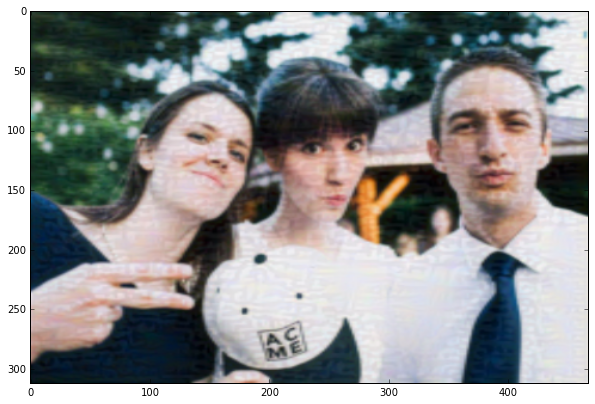

110 Loss: 271044544.0;  Content Loss: 4719677952.0;  Style Loss: 266324864.0
120 Loss: 252947392.0;  Content Loss: 4950424576.0;  Style Loss: 247996960.0
130 Loss: 236941040.0;  Content Loss: 5163384320.0;  Style Loss: 231777648.0
140 Loss: 222694496.0;  Content Loss: 5362537472.0;  Style Loss: 217331952.0
150 Loss: 209938592.0;  Content Loss: 5547298304.0;  Style Loss: 204391296.0
160 Loss: 198467120.0;  Content Loss: 5716227072.0;  Style Loss: 192750896.0
170 Loss: 188078208.0;  Content Loss: 5872864256.0;  Style Loss: 182205344.0
180 Loss: 178653952.0;  Content Loss: 6019364864.0;  Style Loss: 172634592.0
190 Loss: 170049680.0;  Content Loss: 6156795904.0;  Style Loss: 163892880.0
200 Loss: 162167344.0;  Content Loss: 6286636032.0;  Style Loss: 155880704.0


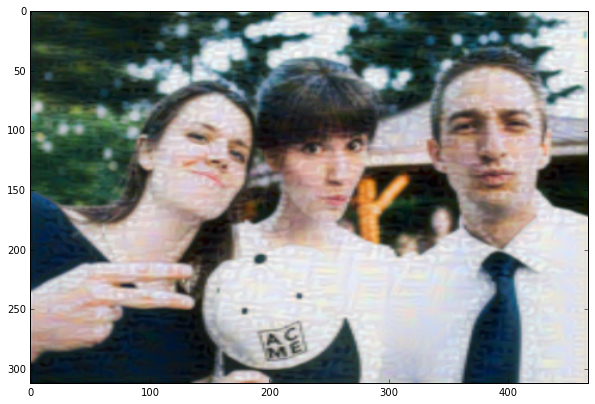

210 Loss: 154934352.0;  Content Loss: 6408422400.0;  Style Loss: 148525936.0
220 Loss: 148286272.0;  Content Loss: 6522098688.0;  Style Loss: 141764176.0
230 Loss: 142162720.0;  Content Loss: 6626487296.0;  Style Loss: 135536240.0
240 Loss: 136501264.0;  Content Loss: 6722426880.0;  Style Loss: 129778832.0
250 Loss: 131249288.0;  Content Loss: 6810693632.0;  Style Loss: 124438592.0
260 Loss: 126380376.0;  Content Loss: 6894728192.0;  Style Loss: 119485648.0
270 Loss: 121848864.0;  Content Loss: 6974692352.0;  Style Loss: 114874168.0
280 Loss: 117633216.0;  Content Loss: 7048971776.0;  Style Loss: 110584248.0
290 Loss: 113695664.0;  Content Loss: 7118151680.0;  Style Loss: 106577512.0
300 Loss: 110010008.0;  Content Loss: 7183834112.0;  Style Loss: 102826176.0


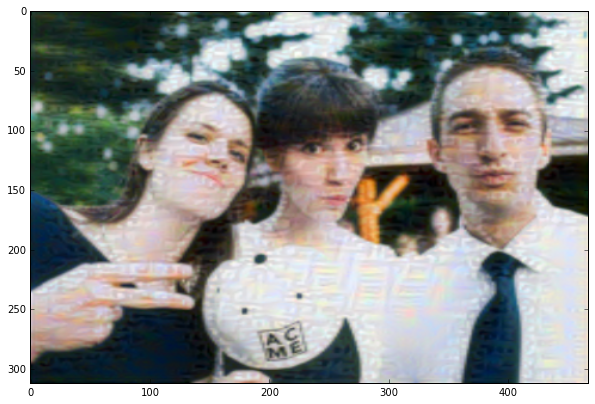

310 Loss: 106556640.0;  Content Loss: 7243761664.0;  Style Loss: 99312880.0
320 Loss: 103315224.0;  Content Loss: 7298663424.0;  Style Loss: 96016560.0
330 Loss: 100268120.0;  Content Loss: 7350903808.0;  Style Loss: 92917216.0
340 Loss: 97398816.0;  Content Loss: 7401530880.0;  Style Loss: 89997288.0
350 Loss: 94688952.0;  Content Loss: 7450840064.0;  Style Loss: 87238112.0
360 Loss: 92126136.0;  Content Loss: 7498352640.0;  Style Loss: 84627784.0
370 Loss: 89699616.0;  Content Loss: 7543206912.0;  Style Loss: 82156408.0
380 Loss: 87398504.0;  Content Loss: 7586497536.0;  Style Loss: 79812008.0
390 Loss: 85217528.0;  Content Loss: 7628457984.0;  Style Loss: 77589072.0
400 Loss: 83147368.0;  Content Loss: 7668277248.0;  Style Loss: 75479088.0


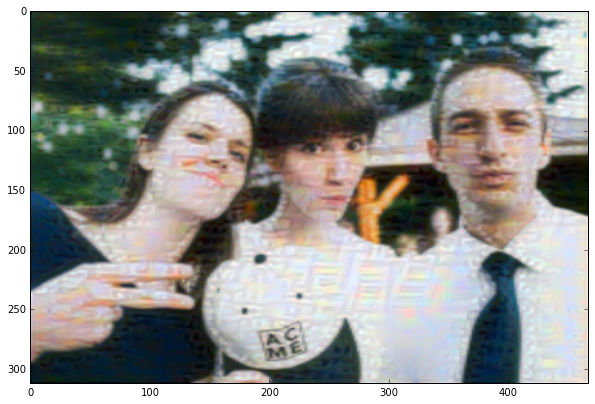

410 Loss: 81179792.0;  Content Loss: 7705869312.0;  Style Loss: 73473920.0
420 Loss: 79307584.0;  Content Loss: 7740913664.0;  Style Loss: 71566672.0
430 Loss: 77521072.0;  Content Loss: 7774624256.0;  Style Loss: 69746448.0
440 Loss: 75816368.0;  Content Loss: 7807487488.0;  Style Loss: 68008880.0
450 Loss: 74191824.0;  Content Loss: 7839159296.0;  Style Loss: 66352668.0
460 Loss: 72640888.0;  Content Loss: 7869571072.0;  Style Loss: 64771316.0
470 Loss: 71162984.0;  Content Loss: 7898010624.0;  Style Loss: 63264972.0
480 Loss: 69747680.0;  Content Loss: 7924514816.0;  Style Loss: 61823168.0
490 Loss: 68390776.0;  Content Loss: 7950385664.0;  Style Loss: 60440392.0
500 Loss: 67091436.0;  Content Loss: 7975691264.0;  Style Loss: 59115744.0


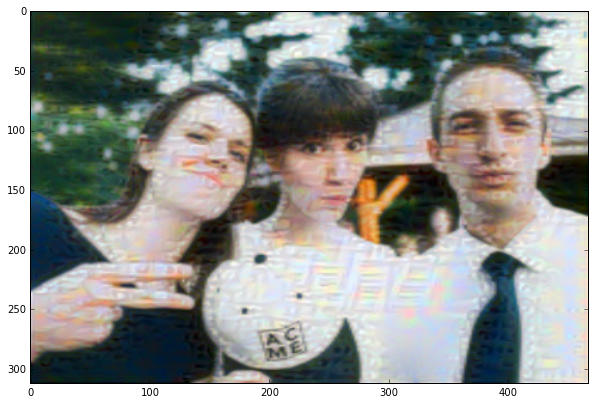

510 Loss: 65844696.0;  Content Loss: 7999116800.0;  Style Loss: 57845580.0
520 Loss: 64649452.0;  Content Loss: 8021103104.0;  Style Loss: 56628348.0
530 Loss: 63501620.0;  Content Loss: 8041510400.0;  Style Loss: 55460108.0
540 Loss: 62398088.0;  Content Loss: 8061746176.0;  Style Loss: 54336340.0
550 Loss: 61337184.0;  Content Loss: 8081679360.0;  Style Loss: 53255504.0
560 Loss: 60317148.0;  Content Loss: 8100604416.0;  Style Loss: 52216544.0
570 Loss: 59335268.0;  Content Loss: 8118824960.0;  Style Loss: 51216444.0
580 Loss: 58390176.0;  Content Loss: 8136430592.0;  Style Loss: 50253744.0
590 Loss: 57479232.0;  Content Loss: 8152728576.0;  Style Loss: 49326504.0
600 Loss: 56600388.0;  Content Loss: 8168704000.0;  Style Loss: 48431684.0


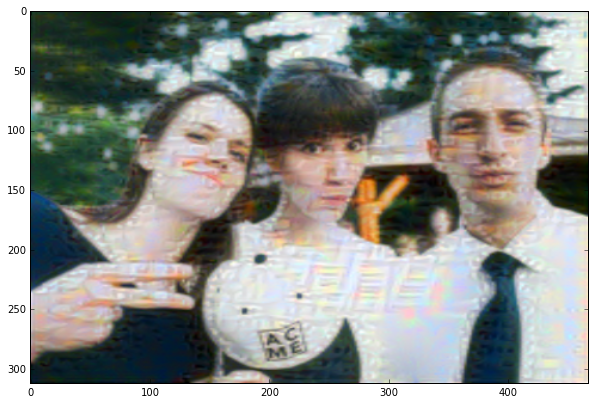

610 Loss: 55751464.0;  Content Loss: 8183950848.0;  Style Loss: 47567512.0
620 Loss: 54930800.0;  Content Loss: 8198644736.0;  Style Loss: 46732156.0
630 Loss: 54139080.0;  Content Loss: 8213335552.0;  Style Loss: 45925744.0
640 Loss: 53374396.0;  Content Loss: 8227919360.0;  Style Loss: 45146476.0
650 Loss: 52634412.0;  Content Loss: 8241619968.0;  Style Loss: 44392792.0
660 Loss: 51917952.0;  Content Loss: 8255291392.0;  Style Loss: 43662660.0
670 Loss: 51224832.0;  Content Loss: 8267880960.0;  Style Loss: 42956952.0
680 Loss: 50553528.0;  Content Loss: 8279929856.0;  Style Loss: 42273596.0
690 Loss: 49903428.0;  Content Loss: 8291350016.0;  Style Loss: 41612076.0
700 Loss: 49273884.0;  Content Loss: 8302922752.0;  Style Loss: 40970960.0


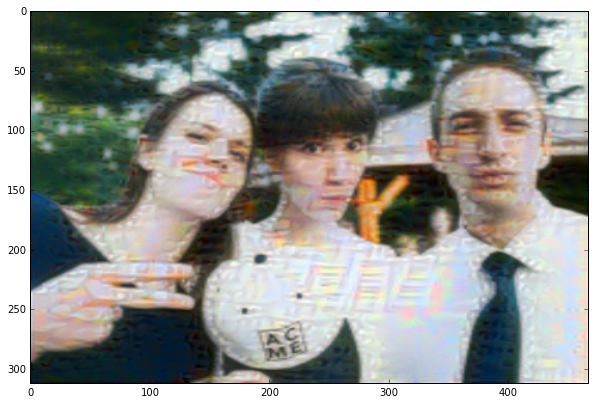

710 Loss: 48663696.0;  Content Loss: 8313699328.0;  Style Loss: 40349996.0
720 Loss: 48071208.0;  Content Loss: 8324233216.0;  Style Loss: 39746976.0
730 Loss: 47495660.0;  Content Loss: 8334023168.0;  Style Loss: 39161636.0
740 Loss: 46937376.0;  Content Loss: 8344001536.0;  Style Loss: 38593376.0
750 Loss: 46395320.0;  Content Loss: 8354132480.0;  Style Loss: 38041188.0
760 Loss: 45868172.0;  Content Loss: 8364826624.0;  Style Loss: 37503344.0
770 Loss: 45354832.0;  Content Loss: 8375094784.0;  Style Loss: 36979736.0
780 Loss: 44855396.0;  Content Loss: 8384861184.0;  Style Loss: 36470536.0
790 Loss: 44370568.0;  Content Loss: 8394202624.0;  Style Loss: 35976364.0
800 Loss: 43899464.0;  Content Loss: 8403327488.0;  Style Loss: 35496136.0


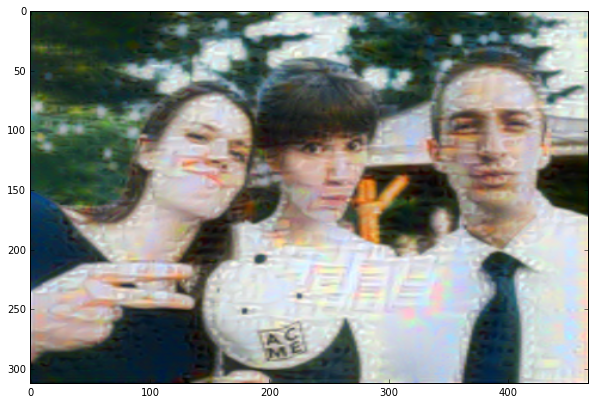

810 Loss: 43441072.0;  Content Loss: 8412478464.0;  Style Loss: 35028592.0
820 Loss: 42994556.0;  Content Loss: 8421447168.0;  Style Loss: 34573108.0
830 Loss: 42560076.0;  Content Loss: 8430960640.0;  Style Loss: 34129116.0
840 Loss: 42137432.0;  Content Loss: 8440044032.0;  Style Loss: 33697388.0
850 Loss: 41725332.0;  Content Loss: 8448895488.0;  Style Loss: 33276436.0
860 Loss: 41324004.0;  Content Loss: 8457517056.0;  Style Loss: 32866486.0
870 Loss: 40933320.0;  Content Loss: 8465605632.0;  Style Loss: 32467712.0
880 Loss: 40552324.0;  Content Loss: 8472825344.0;  Style Loss: 32079498.0
890 Loss: 40180496.0;  Content Loss: 8480136192.0;  Style Loss: 31700358.0
900 Loss: 39818092.0;  Content Loss: 8486861824.0;  Style Loss: 31331230.0


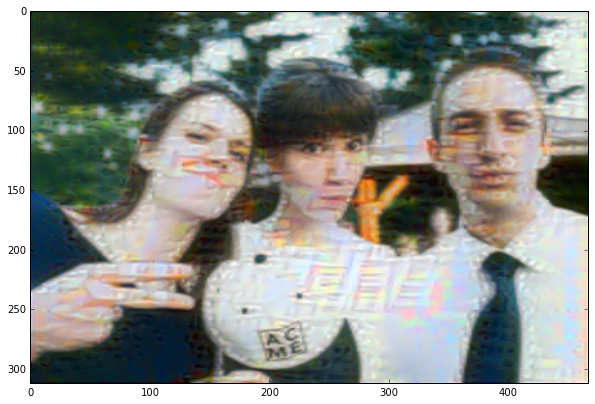

910 Loss: 39465416.0;  Content Loss: 8493372416.0;  Style Loss: 30972042.0
920 Loss: 39121828.0;  Content Loss: 8499324928.0;  Style Loss: 30622502.0
930 Loss: 38786224.0;  Content Loss: 8505109504.0;  Style Loss: 30281114.0
940 Loss: 38458448.0;  Content Loss: 8510943744.0;  Style Loss: 29947502.0
950 Loss: 38138048.0;  Content Loss: 8516547584.0;  Style Loss: 29621502.0
960 Loss: 37824964.0;  Content Loss: 8521049600.0;  Style Loss: 29303914.0
970 Loss: 37518764.0;  Content Loss: 8525223936.0;  Style Loss: 28993540.0
980 Loss: 37219384.0;  Content Loss: 8528855552.0;  Style Loss: 28690526.0
990 Loss: 36926776.0;  Content Loss: 8532120576.0;  Style Loss: 28394656.0
1000 Loss: 36640264.0;  Content Loss: 8535277568.0;  Style Loss: 28104986.0


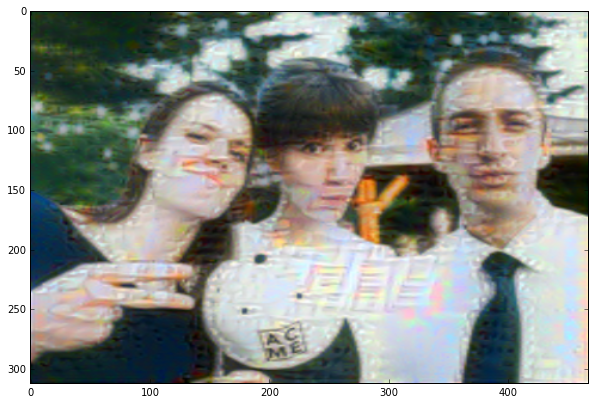

1010 Loss: 36359592.0;  Content Loss: 8538276864.0;  Style Loss: 27821316.0
1020 Loss: 36084824.0;  Content Loss: 8541160960.0;  Style Loss: 27543662.0
1030 Loss: 35815224.0;  Content Loss: 8543764992.0;  Style Loss: 27271460.0
1040 Loss: 35550936.0;  Content Loss: 8545790976.0;  Style Loss: 27005146.0
1050 Loss: 35291916.0;  Content Loss: 8547838976.0;  Style Loss: 26744078.0
1060 Loss: 35038208.0;  Content Loss: 8549615616.0;  Style Loss: 26488592.0
1070 Loss: 34790112.0;  Content Loss: 8551110656.0;  Style Loss: 26239002.0
1080 Loss: 34546768.0;  Content Loss: 8552709632.0;  Style Loss: 25994060.0
1090 Loss: 34308156.0;  Content Loss: 8554692096.0;  Style Loss: 25753464.0
1100 Loss: 34074076.0;  Content Loss: 8556390912.0;  Style Loss: 25517686.0


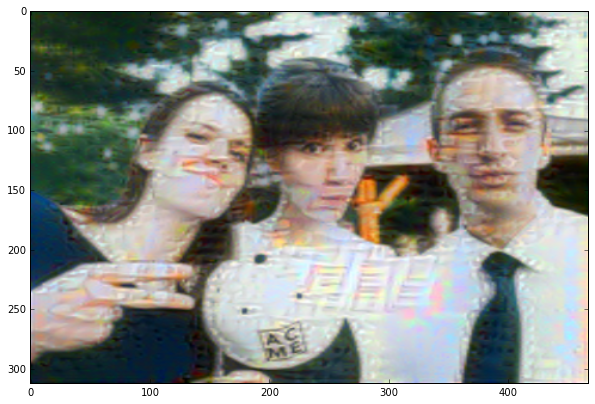

1110 Loss: 33844412.0;  Content Loss: 8558209536.0;  Style Loss: 25286202.0
1120 Loss: 33618924.0;  Content Loss: 8559878656.0;  Style Loss: 25059044.0
1130 Loss: 33397608.0;  Content Loss: 8561460224.0;  Style Loss: 24836146.0
1140 Loss: 33179932.0;  Content Loss: 8562819072.0;  Style Loss: 24617112.0
1150 Loss: 32966308.0;  Content Loss: 8564037120.0;  Style Loss: 24402270.0
1160 Loss: 32756980.0;  Content Loss: 8565521920.0;  Style Loss: 24191458.0
1170 Loss: 32551396.0;  Content Loss: 8566809088.0;  Style Loss: 23984586.0
1180 Loss: 32349726.0;  Content Loss: 8567703552.0;  Style Loss: 23782022.0
1190 Loss: 32151978.0;  Content Loss: 8568395776.0;  Style Loss: 23583582.0
1200 Loss: 31958124.0;  Content Loss: 8568906240.0;  Style Loss: 23389216.0


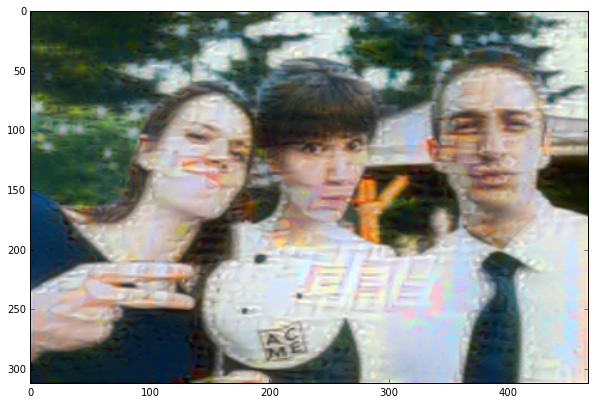

1210 Loss: 31767508.0;  Content Loss: 8569349632.0;  Style Loss: 23198158.0
1220 Loss: 31580104.0;  Content Loss: 8569627648.0;  Style Loss: 23010476.0
1230 Loss: 31395648.0;  Content Loss: 8569903104.0;  Style Loss: 22825744.0
1240 Loss: 31214600.0;  Content Loss: 8570165248.0;  Style Loss: 22644434.0
1250 Loss: 31036468.0;  Content Loss: 8570001408.0;  Style Loss: 22466466.0
1260 Loss: 30861004.0;  Content Loss: 8569944064.0;  Style Loss: 22291060.0
1270 Loss: 30688164.0;  Content Loss: 8570051584.0;  Style Loss: 22118112.0
1280 Loss: 30518506.0;  Content Loss: 8569627648.0;  Style Loss: 21948878.0
1290 Loss: 30351584.0;  Content Loss: 8569072128.0;  Style Loss: 21782510.0
1300 Loss: 30187560.0;  Content Loss: 8568749056.0;  Style Loss: 21618812.0


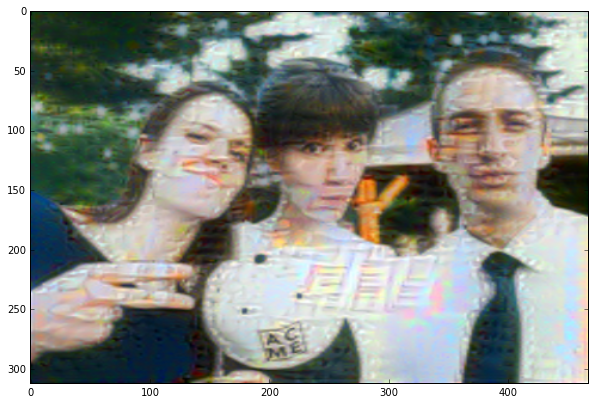

1310 Loss: 30026568.0;  Content Loss: 8568193024.0;  Style Loss: 21458374.0
1320 Loss: 29868130.0;  Content Loss: 8567571968.0;  Style Loss: 21300558.0
1330 Loss: 29712170.0;  Content Loss: 8566771200.0;  Style Loss: 21145398.0
1340 Loss: 29558824.0;  Content Loss: 8566222848.0;  Style Loss: 20992602.0
1350 Loss: 29407982.0;  Content Loss: 8565567488.0;  Style Loss: 20842414.0
1360 Loss: 29259540.0;  Content Loss: 8564910080.0;  Style Loss: 20694630.0
1370 Loss: 29113512.0;  Content Loss: 8564240384.0;  Style Loss: 20549270.0
1380 Loss: 28970054.0;  Content Loss: 8563665920.0;  Style Loss: 20406388.0
1390 Loss: 28828704.0;  Content Loss: 8562988544.0;  Style Loss: 20265716.0
1400 Loss: 28689612.0;  Content Loss: 8562181632.0;  Style Loss: 20127430.0


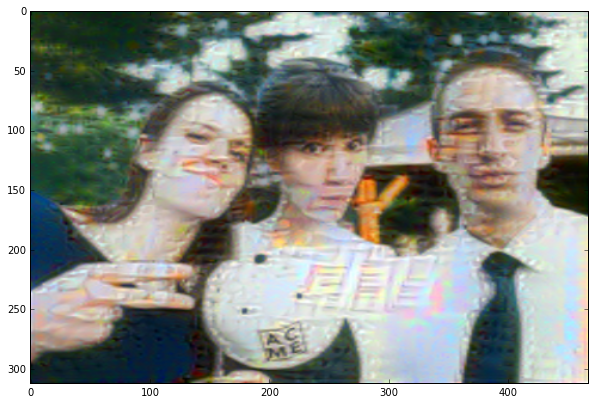

1410 Loss: 28552784.0;  Content Loss: 8561126400.0;  Style Loss: 19991656.0
1420 Loss: 28418096.0;  Content Loss: 8560156672.0;  Style Loss: 19857940.0
1430 Loss: 28285284.0;  Content Loss: 8558890496.0;  Style Loss: 19726394.0
1440 Loss: 28154356.0;  Content Loss: 8556890624.0;  Style Loss: 19597464.0
1450 Loss: 28025274.0;  Content Loss: 8555049984.0;  Style Loss: 19470224.0
1460 Loss: 27897910.0;  Content Loss: 8553405440.0;  Style Loss: 19344504.0
1470 Loss: 27772124.0;  Content Loss: 8551422976.0;  Style Loss: 19220700.0
1480 Loss: 27648244.0;  Content Loss: 8549485568.0;  Style Loss: 19098758.0
1490 Loss: 27526078.0;  Content Loss: 8547535872.0;  Style Loss: 18978542.0
1500 Loss: 27405870.0;  Content Loss: 8545451520.0;  Style Loss: 18860418.0


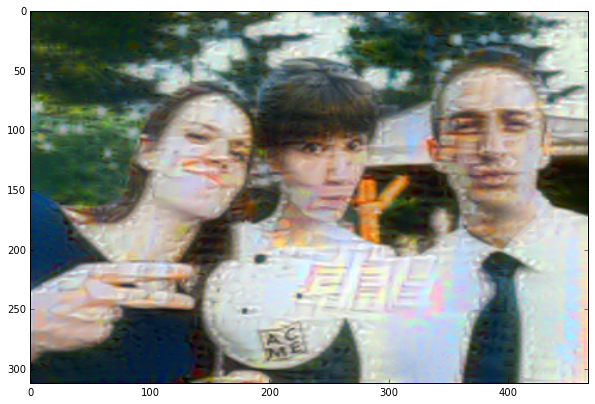

1510 Loss: 27287048.0;  Content Loss: 8543664128.0;  Style Loss: 18743384.0
1520 Loss: 27169610.0;  Content Loss: 8541831168.0;  Style Loss: 18627778.0
1530 Loss: 27053982.0;  Content Loss: 8539584000.0;  Style Loss: 18514398.0
1540 Loss: 26940360.0;  Content Loss: 8537325568.0;  Style Loss: 18403034.0
1550 Loss: 26828272.0;  Content Loss: 8535010304.0;  Style Loss: 18293262.0


KeyboardInterrupt: 

In [43]:
iters=0
for i in xrange(2000):
    if i%10==0:
        t_loss, c_loss, s_loss = sess.run([total_loss, content_loss, style_loss])
        print i, "Loss: {0};  Content Loss: {1};  Style Loss: {2}".format(t_loss, c_loss, s_loss)

    sess.run(optim)
    if i%100==0:
        tmp_img = tf.clip_by_value( opt_img, 0.0, 255.0 )
        sess.run( opt_img.assign( tmp_img ))
        image = sess.run(opt_img)/255.
        image = image.reshape((224, 224, 3))
        image = imresize( image, (312, 468) )
        # imsave("test_img.png", image)
        plt.imsave("van_gogh_wedding{}.jpg".format(iters), image)
        iters += 1
        plt.imshow(image)
        plt.show()
    

## Show Output Image

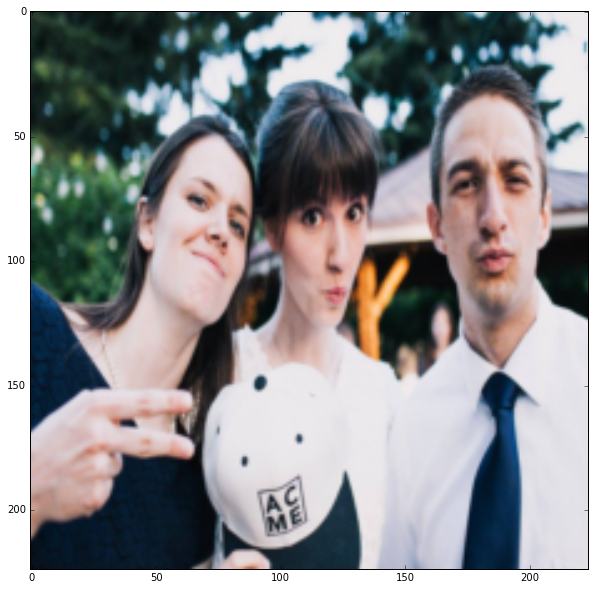

In [33]:
tmp_img = tf.clip_by_value( opt_img, 0.0, 255.0 )
sess.run( opt_img.assign( tmp_img ))
image = sess.run(opt_img)/255.
image = image.reshape((224, 224, 3))
# imsave("test_img.png", image)
plt.imshow(image)
plt.show()

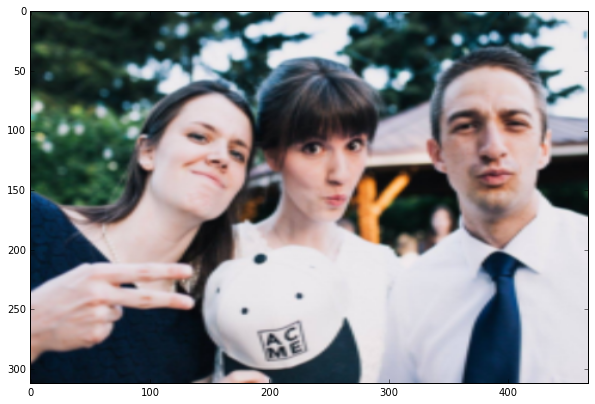

In [34]:
iters=0
tmp_img = tf.clip_by_value( opt_img, 0.0, 255.0 )
sess.run( opt_img.assign( tmp_img ))
image = sess.run(opt_img)/255.
image = image.reshape((224, 224, 3))
# imsave("test_img.png", image)
plt.imsave("van_gogh_wedding{}.jpg".format(iters), image)
plt.imshow(imresize( image, (312, 468) ))
plt.show()